In [1]:
import pylab as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline 

import numpy as np
import pandas as pd

from sklearn.datasets import make_circles, load_boston

from sklearn.model_selection import train_test_split as tts

from sklearn.linear_model import LinearRegression as LinReg
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

# This filters ALL warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\ragod\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ragod\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\ragod\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#Importacion de datos
df_lici1 = pd.read_excel(r'C:\Users\ragod\Desktop\Contratos2\2021.xlsx', sheet_name='Licitaciones')
df_result1 = pd.read_excel(r'C:\Users\ragod\Desktop\Contratos2\2021.xlsx', sheet_name='Resultados')

In [3]:
df_lici1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145470 entries, 0 to 145469
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Identificador                145470 non-null  int64         
 1   Link licitación              145470 non-null  object        
 2   Fecha actualización          145470 non-null  datetime64[ns]
 3   Vigente/Anulada/Archivada    145470 non-null  object        
 4   Valor estimado del contrato  144780 non-null  float64       
 5   CPV                          144131 non-null  object        
 6   Tipo de contrato             145470 non-null  object        
 7   Órgano de Contratación       145470 non-null  object        
 8   Tipo de Administración       145470 non-null  object        
 9   Tipo de procedimiento        145470 non-null  object        
 10  Sistema de contratación      141855 non-null  object        
 11  Subcontratación permitida 

In [4]:
df_result1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180656 entries, 0 to 180655
Data columns (total 9 columns):
 #   Column                                                                  Non-Null Count   Dtype         
---  ------                                                                  --------------   -----         
 0   Identificador                                                           180656 non-null  int64         
 1   Link licitación                                                         180656 non-null  object        
 2   Fecha actualización                                                     180656 non-null  datetime64[ns]
 3   Resultado licitación/lote                                               180656 non-null  object        
 4   Precio de la oferta más baja por licitación/lote                        91409 non-null   float64       
 5   Precio de la oferta más alta por licitación/lote                        93922 non-null   float64       
 6   Se han excluí

In [5]:
#Renombre de columnas
nuevas_col_lici =['identificador','link','fecha',
       'vigencia',
       'precio_lici',
       'cpv',
       'tipo_cont',
       'org_cont',
       'tipo_admi',
        'tipo_pro',
        'sist_cont',
        'subcontratacion']
nuevas_col_result =['identificador', 'link','fecha','resultado',
       'precio_min',
       'precio_max',
       'baja_tem',
       'precio_adj_sin_imp',
       'precio_adj_con_imp']



In [6]:
df_lici1=df_lici1.rename(columns={k:v for k,v in zip(df_lici1.columns, nuevas_col_lici)})
df_result1=df_result1.rename(columns={k:v for k,v in zip(df_result1.columns, nuevas_col_result)})

In [7]:
#Eliminacion columnas por no estar en el estudio
df_lici1.drop(['link','fecha','vigencia','org_cont','tipo_admi','subcontratacion'],axis = 1,inplace = True)
df_result1.drop(['link','fecha'],axis = 1,inplace = True)

Estudio de varibles de df_lici1
    identificador debe ser cadena ya que es una clave
    precio_lici contiene nulos.- 
    cpv contiene varios valores.- se reduce a 1

Estudio de variables de df_result1
    identificador debe ser cadena ya que es una clave
    figuran valores por lotes.- reducir a un valor solo por identificador sumando campos precio
    campos precio con vlaor nulo, transformar inicialmente con 0. Con posteriordad, al agrupar se suman. En     el caso de unico valor rellenar min y max con el de ajudicacion.
    campo baja_temp debe tomar valores 0/1. rellenar los nulos con 0.

Solo se seleccionan los adjudicados de result1, el resto se eliman, asi como los de lici1 de igual identificador
    

In [8]:
# Modificaciones de df_lici_1
df_lici2 = df_lici1
df_lici2.identificador = df_lici2.identificador.astype('string')


In [9]:
#Modifciaciones de df_resutl1
df_result2 = df_result1
df_result2.identificador = df_result2.identificador.astype('string')
df_result2 = df_result2.fillna(0)

In [10]:
df_lici2.head()

,identificador,precio_lici,cpv,tipo_cont,tipo_pro,sist_cont
0,1001315,27300.0,63513000;79956000;79952000;79950000;,Servicios,Negociado sin publicidad,No aplica
1,1001606,910892.0,34933000;,Suministros,Negociado con publicidad,NaN
2,1001783,34034.0,92600000;,Servicios,Negociado sin publicidad,No aplica
3,1002267,240000.0,98351000;,Gestión de Servicios Públicos,Abierto,NaN
4,1007145,2472400.0,32524000;,Suministros,Negociado con publicidad,NaN


In [11]:
df_result2.head()

,identificador,resultado,precio_min,precio_max,baja_tem,precio_adj_sin_imp,precio_adj_con_imp
0,8689190,Adjudicado,19816.45,20000.00,0.0,20000.00,24200.00
1,8723412,Adjudicado,17656.32,18655.68,0.0,17656.32,21364.15
2,8303894,Adjudicado,49852.00,49852.00,0.0,41200.00,49852.00
3,8005484,Adjudicado,0.00,0.00,0.0,8857959.09,10718130.50
4,8005484,Adjudicado,0.00,0.00,0.0,8776679.14,10619781.76


In [12]:
# Seleccion solo de los adjudicados.
#Aquellos que tienen un lote no adjudicado se eliminan todos por no tener detalle de licitacion
#identificacion no adjudicados en resultados
lista_no_adjudica = df_result2.identificador[df_result2.resultado != 'Adjudicado']
lista_no_adjudica_result_index = df_result2[df_result2.identificador.isin(lista_no_adjudica)].index

#deteccion de no adjuidcados en liccitaciones
lista_no_adjudicados=list(lista_no_adjudica.unique())
lista_no_adjudica_lici_index = df_lici2[df_lici2.identificador.isin(lista_no_adjudicados)].index

#Deteccion de adjudicados
licitaciones_adjudicadas_index=[i for i in df_lici2.index if i not in lista_no_adjudica_lici_index]
resultados_adjudicados_index=[i for i in df_result2.index if i not in lista_no_adjudica_result_index]


In [13]:
# Eliminacion de no ejecutados
df_lici3 = df_lici2.iloc[licitaciones_adjudicadas_index].reset_index(drop=True)
df_result3   = df_result2.iloc[resultados_adjudicados_index].reset_index(drop=True)

In [14]:
# Elimino aquellos adjudicados con precio de adjudicacion 0

df_result3 = df_result3[df_result3.precio_adj_sin_imp != 0]

In [15]:
# Agrupacion de resultados por identificador

df_result4 = df_result3.groupby('identificador',as_index = False).sum()


In [16]:
#Asignacion de valors max y min cuando son 0.
df_result4.loc[(df_result4.precio_min==0)&(df_result4.precio_max==0),['precio_min','precio_max']]=df_result4['precio_adj_sin_imp']


In [17]:
df_result4

,identificador,precio_min,precio_max,baja_tem,precio_adj_sin_imp,precio_adj_con_imp
0,1001606,627201.77,627201.77,0.0,627201.77,758914.14
1,1002267,111500.00,111500.00,0.0,111500.00,111500.00
2,1007145,2472399.73,2472399.73,0.0,2472399.73,2933884.48
3,1007418,1507220.00,1507220.00,0.0,1507220.00,1823736.20
4,1007814,116482.24,149691.36,0.0,116482.24,124636.00
...,...,...,...,...,...,...
106416,985152,204744.80,204744.80,0.0,204744.80,247741.21
106417,985194,15205406.79,15205406.79,0.0,15205406.79,18398542.22
106418,991030,935574.20,935574.20,0.0,935574.20,1001064.39
106419,996489,262800.00,262800.00,0.0,262800.00,317988.00


In [18]:
identificador_result = list(df_result4.identificador)


In [19]:
df_lici3[df_lici3['identificador'].isin ( df_result4.identificador)]


,identificador,precio_lici,cpv,tipo_cont,tipo_pro,sist_cont
0,1001606,910892.00,34933000;,Suministros,Negociado con publicidad,NaN
1,1002267,240000.00,98351000;,Gestión de Servicios Públicos,Abierto,NaN
2,1007145,2472400.00,32524000;,Suministros,Negociado con publicidad,NaN
3,1007418,3720000.00,90910000;,Servicios,Abierto,NaN
4,1007814,261584.00,98341130;,Servicios,Normas internas,No aplica
...,...,...,...,...,...,...
134190,985152,1322880.00,60160000;,Servicios,Negociado con publicidad,NaN
134191,985194,27239507.00,45234110;,Obras,Abierto,NaN
134192,991030,1383385.39,45331000;,Obras,Negociado con publicidad,No aplica
134194,996489,554040.00,50413200;,Servicios,Abierto,NaN


In [20]:


df_final=df_lici3.join(df_result4.set_index('identificador'), on ='identificador', how = 'right')

In [21]:
# elimino licitaciones sin precio
df_final2=df_final[df_final.precio_lici.isnull()== False]

#elimino licitaciones menores que el adjudicado

df_final2 = df_final2[(df_final2.precio_lici < df_final2.precio_adj_sin_imp) == False]

#elimino licitaciones con importe 0

df_final2 = df_final2[df_final2.precio_lici != 0 ]

# elimino las licitaciones con cpv nulo

df_final2=df_final2[df_final2.cpv.isnull()== False]


In [22]:
df_final2

,identificador,precio_lici,cpv,tipo_cont,tipo_pro,sist_cont,precio_min,precio_max,baja_tem,precio_adj_sin_imp,precio_adj_con_imp
0,1001606,910892.00,34933000;,Suministros,Negociado con publicidad,NaN,627201.77,627201.77,0.0,627201.77,758914.14
1,1002267,240000.00,98351000;,Gestión de Servicios Públicos,Abierto,NaN,111500.00,111500.00,0.0,111500.00,111500.00
2,1007145,2472400.00,32524000;,Suministros,Negociado con publicidad,NaN,2472399.73,2472399.73,0.0,2472399.73,2933884.48
3,1007418,3720000.00,90910000;,Servicios,Abierto,NaN,1507220.00,1507220.00,0.0,1507220.00,1823736.20
4,1007814,261584.00,98341130;,Servicios,Normas internas,No aplica,116482.24,149691.36,0.0,116482.24,124636.00
...,...,...,...,...,...,...,...,...,...,...,...
134189,984860,11061404.96,45252130;90481000;45259100;,Gestión de Servicios Públicos,Abierto,NaN,3390923.01,3390923.01,0.0,3390923.01,3765087.82
134190,985152,1322880.00,60160000;,Servicios,Negociado con publicidad,NaN,204744.80,204744.80,0.0,204744.80,247741.21
134191,985194,27239507.00,45234110;,Obras,Abierto,NaN,15205406.79,15205406.79,0.0,15205406.79,18398542.22
134192,991030,1383385.39,45331000;,Obras,Negociado con publicidad,No aplica,935574.20,935574.20,0.0,935574.20,1001064.39


In [23]:
df_final2.groupby('tipo_pro').count()

,identificador,precio_lici,cpv,tipo_cont,sist_cont,precio_min,precio_max,baja_tem,precio_adj_sin_imp,precio_adj_con_imp
tipo_pro,,,,,,,,,,
Abierto,34370,34370,34370,34370,32596,34370,34370,34370,34370,34370
Abierto simplificado,37253,37253,37253,37253,36651,37253,37253,37253,37253,37253
Derivado de acuerdo marco,13424,13424,13424,13424,13424,13424,13424,13424,13424,13424
Diálogo competitivo,5,5,5,5,4,5,5,5,5,5
Licitación con negociación,86,86,86,86,85,86,86,86,86,86
Negociado con publicidad,844,844,844,844,773,844,844,844,844,844
Negociado sin publicidad,12445,12445,12445,12445,12278,12445,12445,12445,12445,12445
Normas internas,2178,2178,2178,2178,2131,2178,2178,2178,2178,2178
Otros,13,13,13,13,13,13,13,13,13,13


In [24]:
# Par no distorsionar información. El estudio se centrará en los procedimientos de contrato más comunes.

df_final3 =df_final2[(df_final2.tipo_pro=='Abierto')|(df_final2.tipo_pro =='Abierto simplificado')]

In [25]:
df_final3.describe().style.format(precision=2)


,precio_lici,precio_min,precio_max,baja_tem,precio_adj_sin_imp,precio_adj_con_imp
count,71623.00,71623.00,71623.00,71623.00,71623.00,71623.00
mean,853402.28,402579.76,470219.83,0.02,457855.78,533858.89
std,10911458.68,6846622.18,7106293.08,0.34,7217779.23,8077962.57
min,0.01,0.00,0.00,0.00,0.01,0.01
25%,38811.50,14950.00,22500.00,0.00,21735.33,25289.00
50%,89902.35,46500.00,58182.75,0.00,55158.55,65013.30
75%,249989.00,135534.10,164189.17,0.00,155486.50,182713.31
max,1584728506.91,1462355341.81,1508578001.56,39.00,1487654353.47,1636419788.82


In [26]:
df_final3.groupby('tipo_cont').count()

,identificador,precio_lici,cpv,tipo_pro,sist_cont,precio_min,precio_max,baja_tem,precio_adj_sin_imp,precio_adj_con_imp
tipo_cont,,,,,,,,,,
Administrativo especial,152,152,152,152,140,152,152,152,152,152
Colaboración entre el sector público y sector privado,6,6,6,6,6,6,6,6,6,6
Concesión de Obras,16,16,16,16,16,16,16,16,16,16
Concesión de Obras Públicas,2,2,2,2,2,2,2,2,2,2
Concesión de Servicios,464,464,464,464,451,464,464,464,464,464
Gestión de Servicios Públicos,44,44,44,44,30,44,44,44,44,44
Obras,16816,16816,16816,16816,16395,16816,16816,16816,16816,16816
Patrimonial,292,292,292,292,291,292,292,292,292,292
Privado,824,824,824,824,804,824,824,824,824,824


In [27]:
# Seleccionamos los tipos de contratos más comunes: Obras, Suministros y Servicios

df_final4 = df_final3[(df_final3.tipo_cont =='Obras')|(df_final3.tipo_cont =='Suministros')|(df_final3.tipo_cont =='Servicios')].reset_index(drop=True)

In [28]:
df_final4.describe().style.format(precision = 2)

,precio_lici,precio_min,precio_max,baja_tem,precio_adj_sin_imp,precio_adj_con_imp
count,69823.00,69823.00,69823.00,69823.00,69823.00,69823.00
mean,814211.98,395616.21,463602.27,0.02,445106.87,520684.69
std,9950806.94,6702362.80,6970779.21,0.34,6894640.47,7724554.55
min,0.01,0.00,0.00,0.00,0.01,0.01
25%,39480.41,15600.00,23364.49,0.00,22502.47,26269.21
50%,90000.00,47700.00,59385.58,0.00,56412.52,66545.16
75%,250605.47,137942.40,166368.42,0.00,158288.40,186370.79
max,1584728506.91,1462355341.81,1508578001.56,39.00,1487654353.47,1636419788.82


In [29]:
df_final4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69823 entries, 0 to 69822
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   identificador       69823 non-null  string 
 1   precio_lici         69823 non-null  float64
 2   cpv                 69823 non-null  object 
 3   tipo_cont           69823 non-null  object 
 4   tipo_pro            69823 non-null  object 
 5   sist_cont           67507 non-null  object 
 6   precio_min          69823 non-null  float64
 7   precio_max          69823 non-null  float64
 8   baja_tem            69823 non-null  float64
 9   precio_adj_sin_imp  69823 non-null  float64
 10  precio_adj_con_imp  69823 non-null  float64
dtypes: float64(6), object(4), string(1)
memory usage: 5.9+ MB


In [31]:
# Para limpiar los datos se mantienen: identificador, precio_lici, tipo_cont, tipo_pro y porce_adju

df_final5=df_final4[['identificador','precio_lici', 'precio_adj_sin_imp','tipo_cont','tipo_pro']]

In [32]:
df_final5.describe().style.format(precision=2)

,precio_lici,precio_adj_sin_imp
count,69823.00,69823.00
mean,814211.98,445106.87
std,9950806.94,6894640.47
min,0.01,0.01
25%,39480.41,22502.47
50%,90000.00,56412.52
75%,250605.47,158288.40
max,1584728506.91,1487654353.47


In [33]:


import pylab as plt
import seaborn as sns

%matplotlib inline

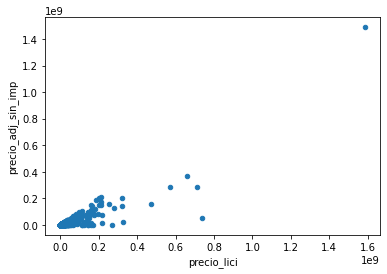

In [34]:
df_final5.plot.scatter(x='precio_lici', y='precio_adj_sin_imp');

In [35]:
stats=df_final5.describe().T

stats['IQR']=stats['75%'] - stats['25%']

stats.style.format(precision =2)

,count,mean,std,min,25%,50%,75%,max,IQR
precio_lici,69823.00,814211.98,9950806.94,0.01,39480.41,90000.00,250605.47,1584728506.91,211125.06
precio_adj_sin_imp,69823.00,445106.87,6894640.47,0.01,22502.47,56412.52,158288.40,1487654353.47,135785.93


In [55]:
outliers=pd.DataFrame(columns=df_final5.columns)
for e in stats.index:
    
    iqr=stats.at[e, 'IQR']
    
    cutoff=2.5*iqr
    
    lower=stats.at[e, '25%']-cutoff
    upper=stats.at[e, '75%']+cutoff
    
    results=df_final5[(df_final5[e]<lower) | (df_final5[e]>upper)].copy()
    
    results['outliers']=e
    
    outliers=outliers.append(results, sort=True)
    
outliers['outliers'].value_counts()

precio_lici           7740
precio_adj_sin_imp    7015
Name: outliers, dtype: int64

In [58]:
lista_outliers = list(outliers.identificador.unique())
lista_outliers_index =df_final5[df_final5.identificador.isin(lista_outliers)].index
lista_final_index = [i for i in df_final5.index if i not in lista_outliers_index]


lista_final_index[:10]

[1, 2, 4, 5, 9, 11, 12, 13, 17, 20]

In [64]:
df_final6 = df_final5.iloc[lista_final_index].reset_index(drop=True)

In [65]:
len(df_final6)

61139

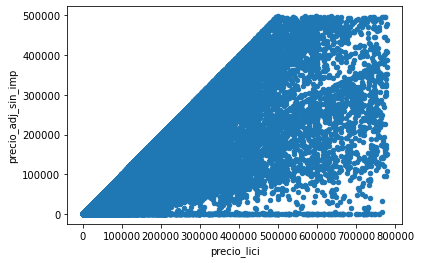

In [66]:
df_final6.plot.scatter(x='precio_lici', y='precio_adj_sin_imp');

In [67]:
df_final6.describe()

,precio_lici,precio_adj_sin_imp
count,61139.000000,61139.000000
mean,127520.248995,80102.686254
std,142419.631140,92085.487952
min,0.010000,0.010000
25%,34700.000000,19800.000000
50%,73553.710000,46411.650000
75%,165289.240000,101906.440000
max,778342.120000,497640.450000


In [70]:
df_final6['por_adj']=df_final6['precio_adj_sin_imp']/df_final6['precio_lici']

In [72]:
df_final6[['precio_lici','precio_adj_sin_imp','por_adj']]

,precio_lici,precio_adj_sin_imp,por_adj
0,416808.96,133888.00,0.321222
1,82644.62,82644.58,1.000000
2,350000.00,68000.00,0.194286
3,189680.00,55318.14,0.291639
4,198000.00,190320.00,0.961212
...,...,...,...
61134,135657.08,30240.23,0.222917
61135,39173.55,19500.00,0.497785
61136,43801.65,14200.00,0.324189
61137,23641.98,23641.98,1.000000


In [ ]:
df_final6.plot.hist('por_adj')